In [14]:
from torch.utils.data import DataLoader, Dataset
import torch

class SquareImageDataset(Dataset):
    def __init__(self, num_samples=100_000):
        img = torch.zeros(1, 32, 32, dtype=torch.float32)
        img[:, 8:24, 8:24] = 1.0
        self.img = img
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.img, 0  # Always returns the same image and label

# Usage:
train_batch_size = 256
train_dataset = SquareImageDataset(num_samples=100_000)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(train_dataset, batch_size=1)

# Example: iterate through a few batches
for x, y in train_loader:
    print(x.shape)  # torch.Size([256, 1, 32, 32])
    break

torch.Size([256, 1, 32, 32])


In [15]:
sample = train_dataset[0]
image = sample[0]

from einops import rearrange
image = rearrange(image, " 1 h w -> h w 1")

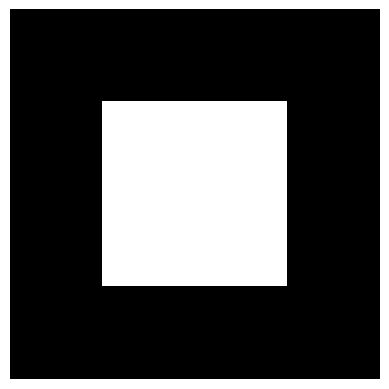

In [16]:
import matplotlib.pyplot as plt


plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


In [18]:
from einops import repeat
import torch
from torch import Tensor, nn
import lovely_tensors as lt
lt.monkey_patch()

class FlowMatchingModel(nn.Module):
    "Flow-matching CNN written with a single nn.Sequential block."
    def __init__(self, img_size: int = 32, kernel_size: int = 3, hidden_dim: int = 64):
        super().__init__()
        self.img_size = img_size
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=hidden_dim, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_dim, out_channels=1, kernel_size=kernel_size, padding=1),
            nn.ReLU()
        )

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        if t.ndim == 0:
            t = t.view(1).repeat(x_t.size(0))
        if t.ndim == 1:
            t = t.view(x_t.size(0), 1, 1, 1)
        elif t.ndim != 4:
            raise ValueError("t must be of shape (), (B,) or (B,1,H,W)")
        t = t.expand(-1, 1, x_t.size(2), x_t.size(3))
        x = torch.cat([x_t, t], dim=1)
        return self.net(x)


In [21]:
from torch.optim import AdamW
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import ODESolver
from flow_matching.utils import ModelWrapper

path = AffineProbPath(scheduler=CondOTScheduler())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fm = FlowMatchingModel(img_size=32, kernel_size=3).to(device)
optim = AdamW(params=fm.parameters(), lr=5e-3)
loss_fn = nn.MSELoss()

num_epochs = 100
for epoch in range(num_epochs):
    fm.train()
    for batch in train_loader:
        x_1 = batch[0].to(device)
        x_0 = torch.randn_like(x_1)
        B, C, H, W = x_0.shape
        t = torch.rand(B, device=device)
        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        x_t = path_sample.x_t
        dx_t = path_sample.dx_t
        pred = fm(x_t, t)
        loss = loss_fn(pred, dx_t)
        optim.zero_grad()
        loss.backward()
        optim.step()
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Loss = {loss.item():.5f}')


Epoch 0: Loss = 0.48017
Epoch 5: Loss = 0.44808
Epoch 10: Loss = 0.44172
Epoch 15: Loss = 0.43861
Epoch 20: Loss = 0.44315
Epoch 25: Loss = 0.43276
Epoch 30: Loss = 0.43278
Epoch 35: Loss = 0.42743
Epoch 40: Loss = 0.43294
Epoch 45: Loss = 0.43509
Epoch 50: Loss = 0.43791
Epoch 55: Loss = 0.43464
Epoch 60: Loss = 0.43836
Epoch 65: Loss = 0.43129
Epoch 70: Loss = 0.43282
Epoch 75: Loss = 0.43143
Epoch 80: Loss = 0.43799
Epoch 85: Loss = 0.43005
Epoch 90: Loss = 0.42830
Epoch 95: Loss = 0.42956


In [22]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

wrapped_vf = WrappedModel(fm)

number_of_steps = 500
step_size = 1 / (number_of_steps * 3)
T = torch.linspace(0, 1, number_of_steps).to(device)

x_init = torch.randn((1, 1, 32, 32), device=device)
solver = ODESolver(velocity_model=wrapped_vf)
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)


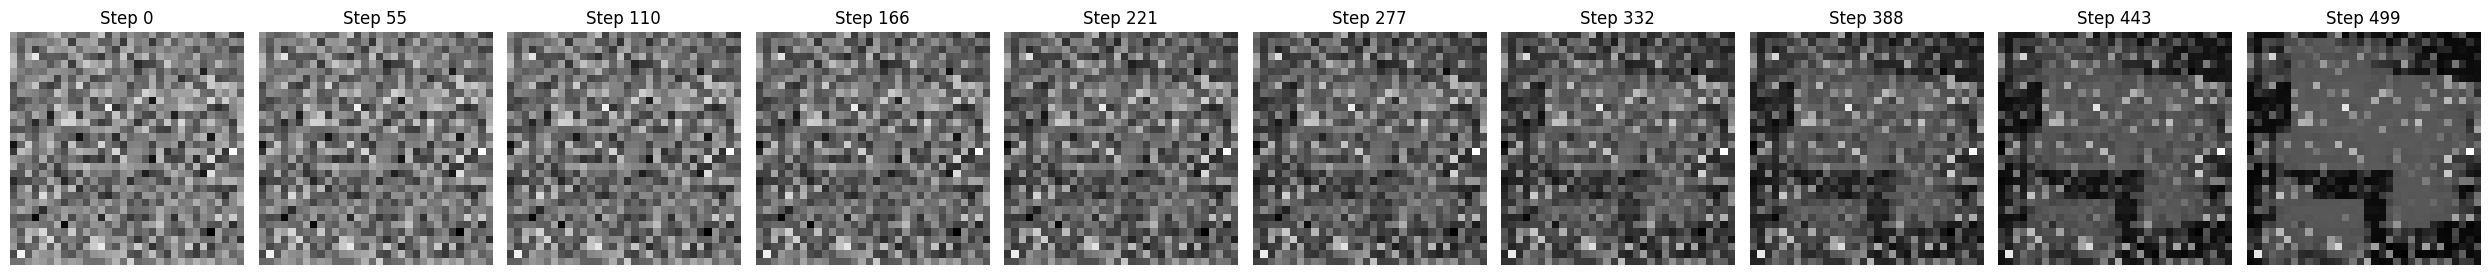

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_evolution(sol, number_of_steps, n_plots=10, title_prefix='Step'):
    images = sol[:number_of_steps, 0]
    plot_indices = np.linspace(0, number_of_steps-1, n_plots, dtype=int)
    plt.figure(figsize=(2.5*n_plots, 3))
    for j, i in enumerate(plot_indices):
        img = images[i].detach().cpu().squeeze().numpy()
        plt.subplot(1, n_plots, j+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f'{title_prefix} {i}')
    plt.tight_layout()
    plt.show()

visualize_image_evolution(sol, number_of_steps, n_plots=10)
